# Inferring Hamiltonians from experimental data with supervised learning

This notebook is modified from notebooks originally developed and used in [Pankaj Mehta's ML for physics course](http://physics.bu.edu/~pankajm/PY580.html) at Boston University. Please check out those notebooks and associated textbooks for additional details and exercises.

Preamble: Run the cells below to import the necessary Python packages

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/supervised_learning_ising.ipynb)



In [59]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
# Comment this out to activate warnings
warnings.filterwarnings('ignore')


# Supervised learning

+ Given a set of inputs $X \in \mathbb{R}^{N_\text{data} \times N_\text{features}}$, construct a function $\hat{y} = f_\theta(X)$ that assigns each input a scalar label $\hat{y} \in \mathbb{R}^{N_\text{data}}$. 

+ **Regression:** $\hat{y}$ is a continuous variable. For example, given a picture of a person, predict their age. In physics, a common example is to predict the energy of a particle given its momentum, or forecast the next step in a time series.

+ **Classification:** $\hat{y}$ is a discrete variable. For example, given a picture of an animal, predict whether it is a cat or a dog. In physics, a common example is to predict whether a phase is ordered or disordered, or to detect whether a signal point is a background, signal, or anomaly.

The function $\hat{y} = f_\theta(X)$ is learned from many instances of labelled data comprising $X \in \mathbb{N_\text{data} \times N_\text{features}}$ and known $y \in \mathbb{N_\text{data}}$ pairs. The "weights" or parameters $\theta$ are adjusted during *training*.


<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/supervised_learning.gif" alt="supervised_learning" style="width: 750px;"/>


*Image from [source](https://github.com/ReiCHU31/Cat-Dog-Classification-Flask-App)*

## Supervised learning infers the generator of a dataset

We can see supervised learning as the process of learning a *generator* for a dataset: given a set of points, can we approximate the underlying process that produced those points?

+ Forecasting: given some past values, predict future values. This approximates the dynamical systems that generate the data.

+ Regression: Given a known generator with unknonw parameters (like a quadratic Hamiltonian with unknown amplitudes), infer those amplitudes. 

+ Classification (most famous example in ML): Given examples of labelled images, states, etc, predict the class of unlabelled data. We can think of the learned decision boundary as defining a generator of new examples belonging to that class (see conditional GANs, etc)

<br><br><br><br><br>

## Spin glasses

A spin glass has a Hamiltonian of the form

$$
  H(\mathbf{s}^{(i)}) = - \sum_{jk} J_{jk} s_{j}^{(i)} \, s_{k}^{(i)}.
$$
where $s_{j}^{(i)} \in \{-1, 1\}$ is the spin of the $j^{th}$ spin in the $i^{th}$ experimental sample $\mathbf{s}^{(i)}$, and $J_{jk}$ is the interaction strength between the $j^{th}$ and $k^{th}$ spins. We assume that there are $L$ spins, and that the sum is over all $L(L-1)/2$ pairs of spins. 

In general, the coupling matrix is not symmetric $J_{jk} \neq J_{kj}$, and the diagonal elements are zero $J_{jj} = 0$ (no self-interactions)

Depending on the coupling matrix $J_{j,k}$, the system can be ferromagnetic, anti-ferromagnetic, or a spin glass. In a ferromagnet, all spins prefer to be aligned ($J_{jk} > 0$). In an anti-ferromagnet, all spins prefer to be anti-aligned ($J_{jk} < 0$). In a many typical spin glasses like the Sherrington-Kirkpatrick model, there is no global preference for alignment or anti-alignment $\langle J_{jk} \rangle_{jk} = 0$. However, the system is frustrated, and the spins cannot simultaneously minimize their energy.

In general, finding the ground state of an arbitrary spin glass is an NP-hard combinatorial optimization problem. 


<br><br><br><br><br>


### Load experimental measurements of an unknown spin glass

+ Suppose we have a spin glass with $L$ spins. 

+ Our data consists of $N_\text{data}$ measurements of microstates $\mathbf{s}^{(i)}$, and their respective energies $E^{(i)} = H(\mathbf{s}^{(i)})$.

In [60]:
import io
from urllib.request import urlopen

raw_url = "https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/spin_energies.npy"
with urlopen(raw_url, timeout=30) as f:
    energies = np.load(io.BytesIO(f.read()), allow_pickle=True)
raw_url = "https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/spin_microstates.npy"
with urlopen(raw_url, timeout=30) as f:
    microstates = np.load(io.BytesIO(f.read()), allow_pickle=True)

print("Microstates shape: ", microstates.shape)
print("Energies shape: ", energies.shape)

Microstates shape:  (10000, 40)
Energies shape:  (10000,)


Text(0, 0.5, 'Number of microstates')

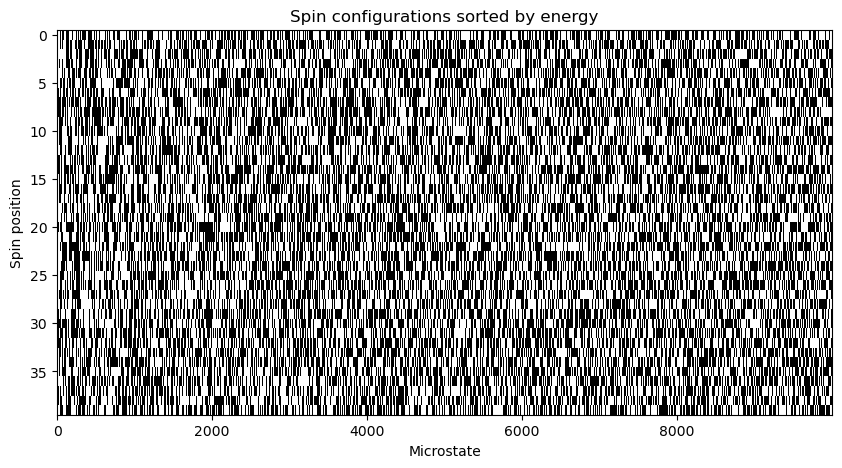

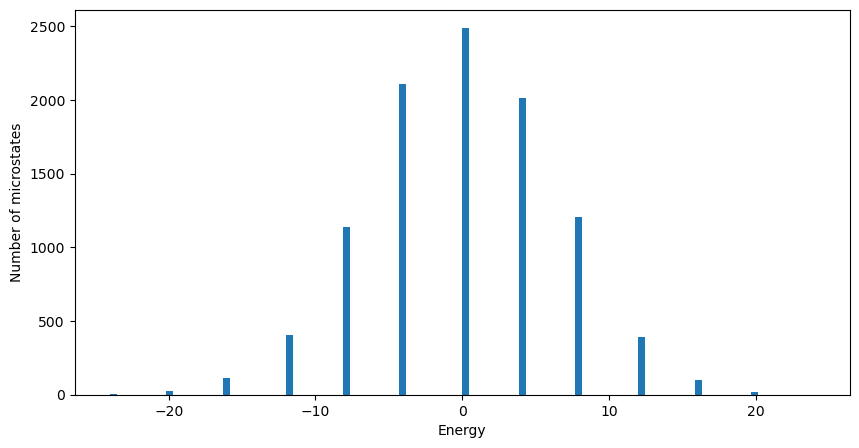

In [6]:


plt.figure(figsize=(10, 5))
plt.imshow(
    microstates[np.argsort(energies)].T, 
    interpolation='nearest', aspect='auto', cmap='binary'
)
plt.ylabel("Spin position")
plt.xlabel("Microstate")
plt.title("Spin configurations sorted by energy")
## aspect ratio
# plt.gca().set_aspect('auto')

plt.figure(figsize=(10, 5))
plt.hist(energies, bins=100)
plt.xlabel("Energy")
plt.ylabel("Number of microstates")


## Can we infer the unknown $J_{jk}$, given only the samples $\mathbf{s}^{(i)}$ and their energies $E^{(i)}$?


Our model class is defined as our known energy function for each sample,

$$
H(\mathbf{s}^{(i)}) = - \sum_{jk} J_{jk} s_{j}^{(i)} \, s_{k}^{(i)}.
$$

We can define the vector $\mathbf{X}^i$ with components

$$
\mathbf{X}^{(i)}_{jk} = s_j^{(i)} s_k^{(i)}.
$$

or, in vector notation,

$$
\mathbf{X}^{(i)} = \mathbf{s}^{(i)} \otimes \mathbf{s}^{(i)}.
$$

Then the energy of each sample is

$$
E^{(i)} = - \sum_{jk} J_{jk} \mathbf{X}^{(i)}_{jk}.
$$

Notice that we've exploited our prior knowledge of the physics of this problem in order to put the problem into a linear form. This represents a sort of *feature engineering* where we've used an *inductive bias* to make the problem easier to solve.


### A note on flattening and indices

+ Our experimental data has three indices: $i$, $j$, and $k$. The index $i$ tells us which experiment we are looking at. But both $j$ and $k$ index *features* of a single experiment.

+ Notice that our Hamiltonian contains a double sum, which indexes into $J$ and the outer product matrix $\mathbf{X}^{(i)}$. Rather than keeping track of two indices, we can convert this into a single sum by flattening these matrices into vectors, alloing us to use a single index over all products of the indices $j$ and $k4

+ Flattening features into a single multiindex is a common technique in machine learning, which we previously used in order to apply PCA to image data. The key distinction here is between the "batch" or "data" index $i$ and the "features" or "parameters" indices $j$ and $k$, and so we will almost never flatten into the batch dimension.


In [8]:
print("microstates shape: ", microstates.shape)

X_all = microstates[:, :, None] * microstates[:, None, :] # outer product creates neighbor matrix
print("X_all shape: ", X_all.shape)

# Data matrix / design matrix always has shape (n_samples, n_features)
X_all = np.reshape(X_all, (X_all.shape[0], -1)) 
print("X_all shape after flattening into data matrix: ", X_all.shape)

# Match our label shape
y_all = energies
print("y_all shape: ", y_all.shape)

microstates shape:  (10000, 40)
X_all shape:  (10000, 40, 40)
X_all shape after flattening into data matrix:  (10000, 1600)
y_all shape:  (10000,)


### Training and testing data

+ Rather than fitting our Hamiltonian model to all of the data, we will split the data into a training set and a test set. 

+ We will fit the model to the training set, and then evaluate the trained model on the test set. 

+ This is a common technique in machine learning, and is used to avoid overfitting.

In [38]:
# define subset of samples
n_samples = 400

# define train and test data sets
X_train, X_test = X_all[:n_samples], X_all[n_samples : 3 * n_samples // 2]
y_train, y_test = y_all[:n_samples], y_all[n_samples : 3 * n_samples // 2]

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape, "\n")

print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (400, 1600)
y_train shape:  (400,) 

X_test shape:  (200, 1600)
y_test shape:  (200,)


We can plot the distribution of energies in the test set, to make sure that it is representative of the training set.

Text(0, 0.5, 'Number of microstates')

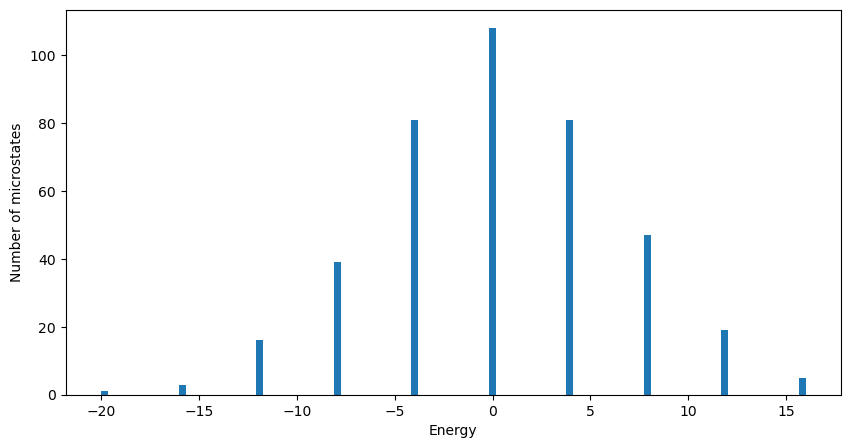

In [39]:
#now we can plot the histogram of the test data
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=100)
plt.xlabel("Energy")
plt.ylabel("Number of microstates")


# Fitting a linear model with least squares

+ Our Hamiltonian is linear with respect to the *outer product* state matrices, we expect that linear regression is a good way to infer the coupling matrix $J_{jk}$.

+ Recall that a linear model is defined as

  $$
    \hat{y} = A \cdot \mathbf{x}
  $$
  where $A$ is a matrix, then $\mathbf{x}$ is a vector of features, and $\hat{y}$ is a vector of predictions. Similarly, the Hamiltonian is linear with respect to the outer product state matrices,
  $$
  E^{(i)} = - \sum_{jk} J_{jk} \mathbf{X}^{(i)}_{jk}.
  $$
  where $\mathbf{X}^{(i)}_{jk} = s_j^{(i)} s_k^{(i)}$. Note the double sum over $j$ and $k$ is equivalent to a single sum over a flattened index. Notice that the matrix $J$ describes **all pairs** of spins, and so it is a $L \times L$ matrix.

+ In our case, the features are the outer product state matrices $\mathbf{X}^{(i)}$, and the predictions are the energies $E^{(i)}$. We can directly solve for the matrix $A$ using the least squares method. Recall that we need to use the Moore-Penrose pseudoinverse because the matrix $\mathbf{X}^T \mathbf{X}$ is not square, and the pseudoinverse is the closest thing to an inverse that we can get.
  $$
    A = \left( \mathbf{X}^T \mathbf{X} \right)^{-1} \mathbf{X}^T \mathbf{y}
  $$

  Recall that we need to use the Moore-Penrose pseudoinverse because the matrix $\mathbf{X}^T \mathbf{X}$ is not square, and the pseudoinverse is the closest thing to an inverse that we can get.

### Using the `scikit-learn` Python library

+ Rather than using numpy, we will use the Python machine learning library `scikit-learn` to perform the linear regression. 

+ `scikit-learn` uses a consistent API for both simple models, like linear regression, and more complex models, like neural networks.

+ You might recognize the structure of `scikit-learn` from other objects in the course: we first *instantiate* an object, and we then *fit* to our data



In [40]:
from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor

## Instantiate the model
model = LinearRegression()
# model = DecisionTreeRegressor()

## Fit the model to the training data. These lines use the normal equations above to solve for the $J$ matrix.
model.fit(X_train, y_train)

## Predict the energies of the training data
y_pred_train = model.predict(X_train)

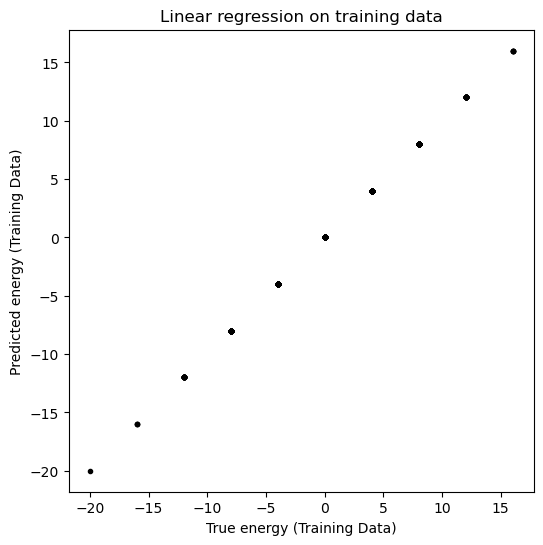

In [41]:
plt.figure(figsize=(6, 6))
# plt.plot(y_train, y_train, "--", zorder=0)
plt.plot(y_train, y_pred_train, ".k", zorder=1)
plt.xlabel("True energy (Training Data)")
plt.ylabel("Predicted energy (Training Data)")
plt.title("Linear regression on training data")
plt.gca().set_aspect('auto')



What about experiments that the model hasn't seen before? We can now use our trained model (with fixed $J$) to predict the energies of new data.

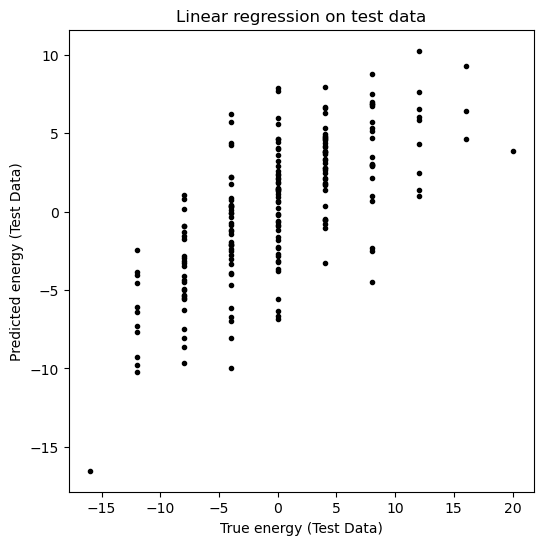

In [42]:
y_pred_test = model.predict(X_test)
# y_pred_test = model.predict(X_test)
plt.figure(figsize=(6, 6))
plt.plot(y_test, y_pred_test, ".k")
plt.xlabel("True energy (Test Data)")
plt.ylabel("Predicted energy (Test Data)")
plt.title("Linear regression on test data")
plt.gca().set_aspect('auto')

### Overfitting
+ High train accuracy just tells us that our model class is capable of expressing patterns found the training data

+ For all datasets, there exists a way to get 100% train accuracy as long as I have access to memory equal to the size of the training dataset (1-nearest-neighbor lookup table)

+ We therefore need to either regularize (training data can't be perfectly fit) or use a test dataset to see how good our model actually is

+ A reasonable heuristic when choosing model complexity is to find one that can just barely overfit train (suggests sufficient power)

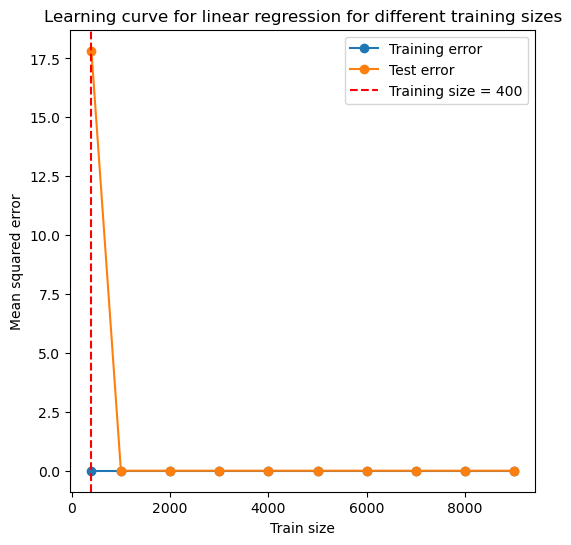

In [36]:
#so far we have been training on a sample of only 400 microstates, while all of our data has 10000 microstates. Let us do a train test split where we hold out 10% of the data for testing
# and train on varying sizes of the remaining data: 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90% of the data.
# We will then plot the training and test error as a function of the number of training size.

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train_all, X_test, y_train_all, y_test= train_test_split(X_all, y_all, train_size=0.9, random_state=0)

train_sizes = np.linspace(1000, 9000,9)
#prepend to train_sizes the size of the training data we have already used (400)
train_sizes = np.concatenate(([400], train_sizes))
train_errors = []
test_errors = []

for train_size in train_sizes:
    X_train, y_train= X_train_all[:int(train_size)], y_train_all[:int(train_size)]
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    train_errors.append(mean_squared_error(y_train, y_pred_train))
    test_errors.append(mean_squared_error(y_test, y_pred_test))

plt.figure(figsize=(6, 6))
plt.plot(train_sizes, train_errors,'o-', label="Training error")
plt.plot(train_sizes, test_errors,'o-',label="Test error")
#add a vertical line at 400 to show where we started training
plt.axvline(x=400, color='r', linestyle='--', label="Training size = 400")
plt.xlabel("Train size")
plt.ylabel("Mean squared error")
plt.legend()
plt.title("Learning curve for linear regression for different training sizes")
plt.show()




### Scoring a trained regression model

We can summarize the performance of a regression model by computing the coefficient of determination, $R^2$. This is a measure of how much of the variance in the data is explained by the model. It is defined as
$$
R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \langle y \rangle)^2}
$$
where $y_i$ is the true value of the $i^{th}$ sample, $\hat{y}_i$ is the predicted value of the $i^{th}$ sample, and $\langle y \rangle$ is the mean of the true values. An $R^2$ of 1 indicates that the model perfectly predicts the data, while an $R^2$ of 0 indicates that the model is no better than predicting the mean of the data.

In [43]:
print("Train $R^2$ was:", model.score(X_train, y_train)) # A measure of model expressivity
print("Test $R^2$ was:", model.score(X_test, y_test)) # A measure of model generalization

Train $R^2$ was: 1.0
Test $R^2$ was: 0.48919097577965953


## But raw score doesn't tell the whole story

+ We can get a great fit, but our model might have a lot of free parameters
+ There might be multiple valid coupling matrices $J$ that explain the observed data
+ Our model might be predictive but not interpretable, or physical
+ We either need more data, better data (sample rarer states), or a better model


## Let's look at the learned coupling matrix, which corresponds to the weights of our fitted model

In [46]:
np.reshape(model.coef_, (40, 40)).shape

(40, 40)

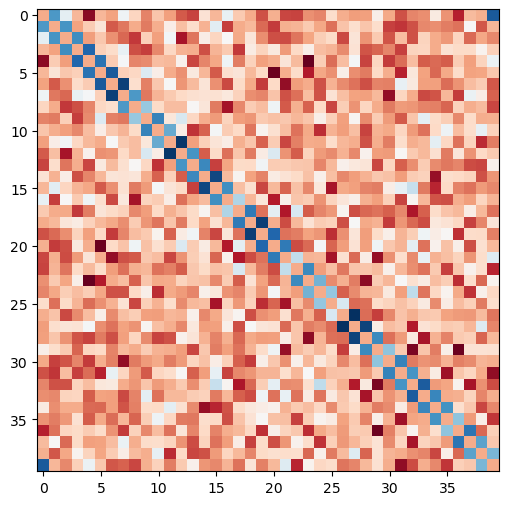

In [47]:
## Because we flattened the data, we need to reshape the coefficients to get the couplings
L = microstates.shape[1]
couplings_estimated = np.array(model.coef_).reshape((L, L))

plt.figure(figsize=(6, 6))
plt.imshow(couplings_estimated, cmap='RdBu_r')

## Let's try repeating the model fitting on different subsets of our experimental data

+ To see how robust our model is, we repeat our fitting procedure on different subsets of the training data. To make these, we randomly sample samples along the batch dimension, and then fit the model to these samples and then visualize the learned coupling matrix $J_{jk}$ as a matrix.

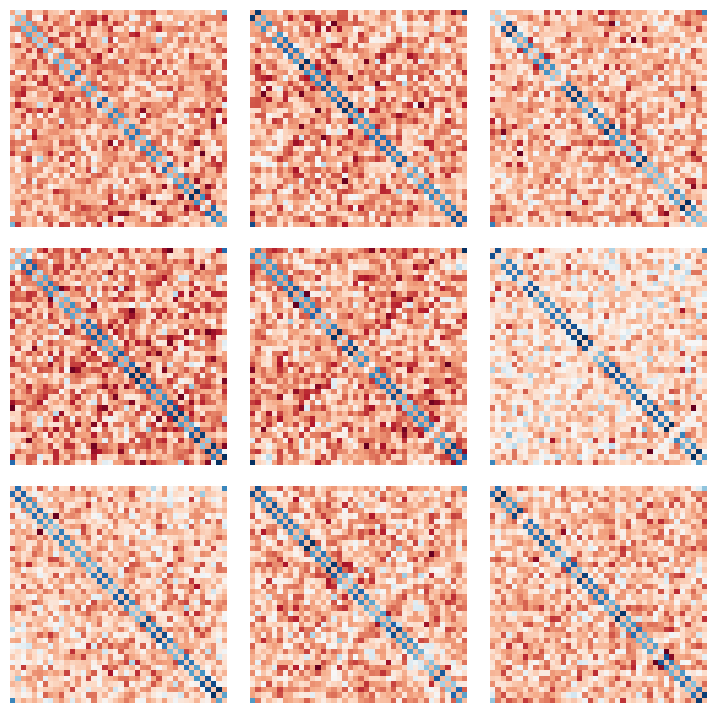

In [ ]:


plt.figure(figsize=(9, 9))
## Plot 3 x 3 subplots

n_samples = 400
for i in range(9):

    ## Pick random training data set
    selection_inds = np.random.choice(range(X_all.shape[0]), size=n_samples, replace=False)
    X_train, y_train = X_all[selection_inds], y_all[selection_inds]
    model = LinearRegression()
    model.fit(X_all[selection_inds], y_all[selection_inds])
    couplings_estimated = np.array(model.coef_).reshape((L, L))
    
    ## Plot learned coupling matrix
    plt.subplot(3, 3, i + 1)
    plt.imshow(couplings_estimated, cmap='RdBu_r')
    plt.axis('off')

# spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)





    

## We can see that there is *variance* in the fitted models. While they have some similarities, the fitted parameters (weights) vary from replicate to replicate

+ In machine learning, there are three ways to reduce the variance of a model: increase the amount of data, or constrain the model class to have fewer (or effectively fewer) free parameters, by introducing *bias* towards a particular set of weights.

<br><br><br><br><br><br><br><br>

# Narrowing the model class with regularization

+ We constrain the model's allowed space of valid representations in order to select for more parsimonious models

+ Operationally, regularizers/constraints reduce the "effective" number of parameters, and thus complexity, of our model

+ Imposing preferred basis functions or symmetries can be forms of regularization


### The loss function of least-squares fitting

+ The least-squares problem is equivalent to finding the optimal $J$ that minimizes the following objective function, the mean squared error between the model energies and true energies
$$
\mathcal{L} = \sum_{i=1}^{N_{data}} (\mathbf{X}^{(i)} \cdot \mathbf{J}- E^{(i)})^2
$$ 
+ where $i$ indicates different training examples, which have predicted energies given by $\mathbf{X}^i \cdot \mathbf{J}$ and observed energies of $H^i$

+ Common regularizers associated loss with the trainable parameters of the model. 




**Ridge regression** is also known as $L2$ regularization, and it discourages any particular weight in the coefficient matrix from becoming too large. Ridge imposes a degree of smoothness or regularity across how a model treats its various inputs. Models that take continuous data as inputs (such as time series, or images), may benefit from the ridge term.

If $\mathbf{J}$ is our trainable linear regression weight matrix (and, in this context, our best estimate for the spin-spin interaction matrix), then we can modify the the losses as follows:
$$
\mathcal{L}_{Ridge} = \sum_{i=1}^{N_{data}} (\mathbf{X}^{(i)} \cdot \mathbf{J}- E^{(i)})^2 + \lambda \sum_{jk} J_{jk}^2
$$



**Lasso** is also known as $L1$ or sparse regularization, encourages *sparsity* in weight space: it incentivizes models where most coefficients go to zero, thereby reducing the model's dependencies on features. Lasso is often used in feature selection, where we want to identify the most important features in a dataset.

$$
\mathcal{L}_{Lasso} = \sum_{i=1}^{N_{data}} (\mathbf{X}^{(i)} \cdot \mathbf{J}- E^{(i)})^2 + \lambda \sum_{jk} | J_{jk} |
$$
where the hyperparameter $\lambda$ determines the "strength" of the penalty terms.


Let's try re-fitting the model with these different regularizers. We will vary $\lambda$, the strength of the regularization, and see how the learned coupling matrix changes.

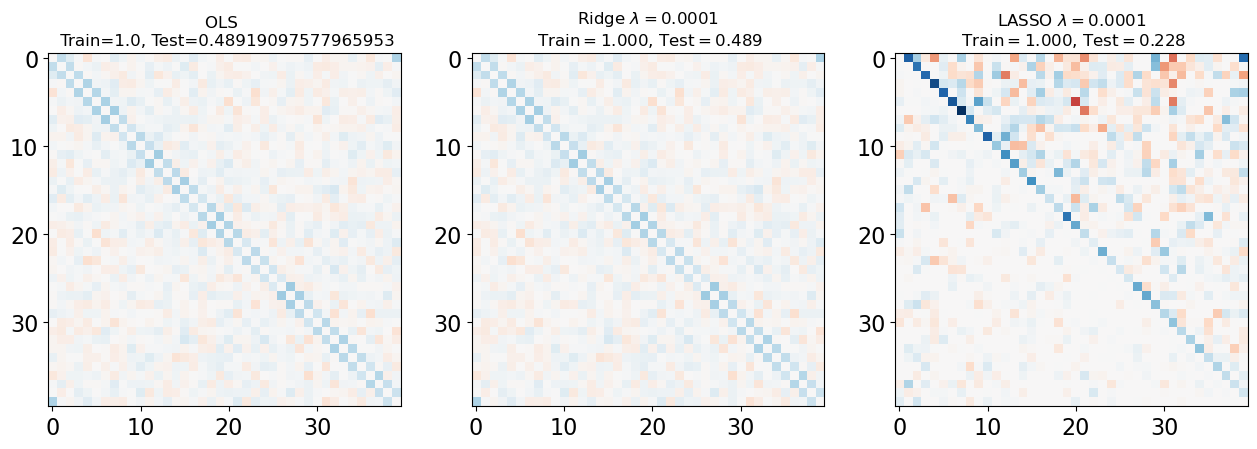

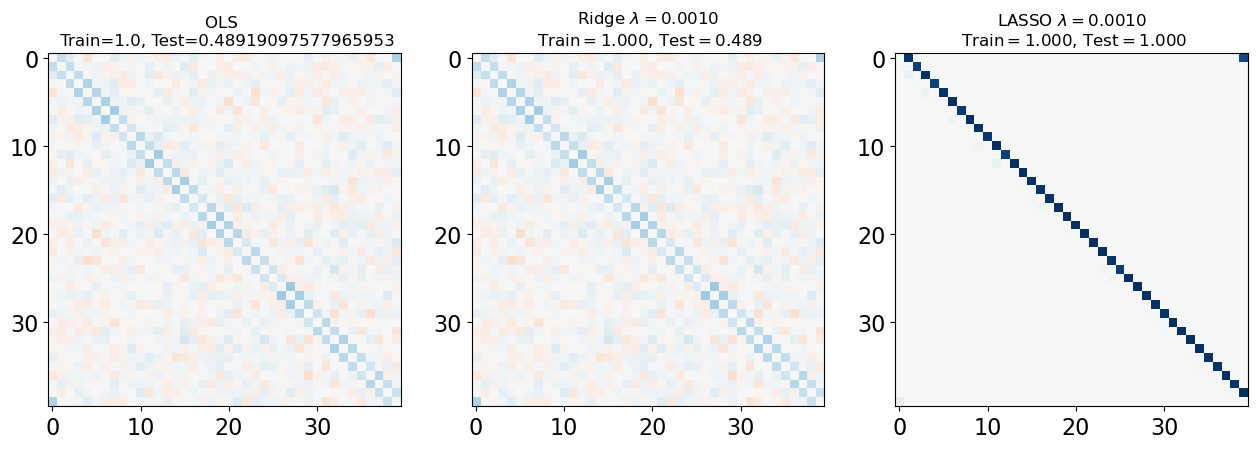

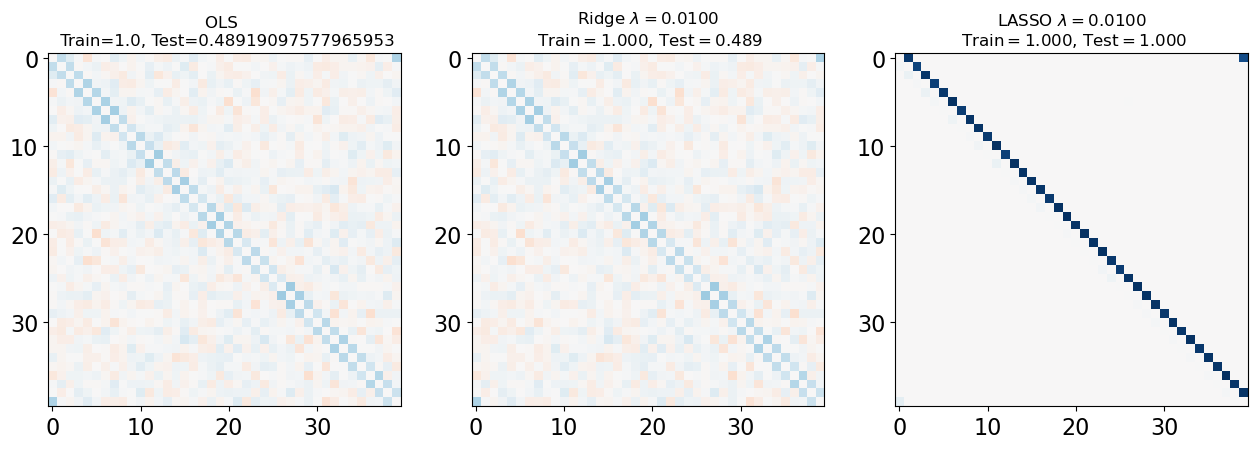

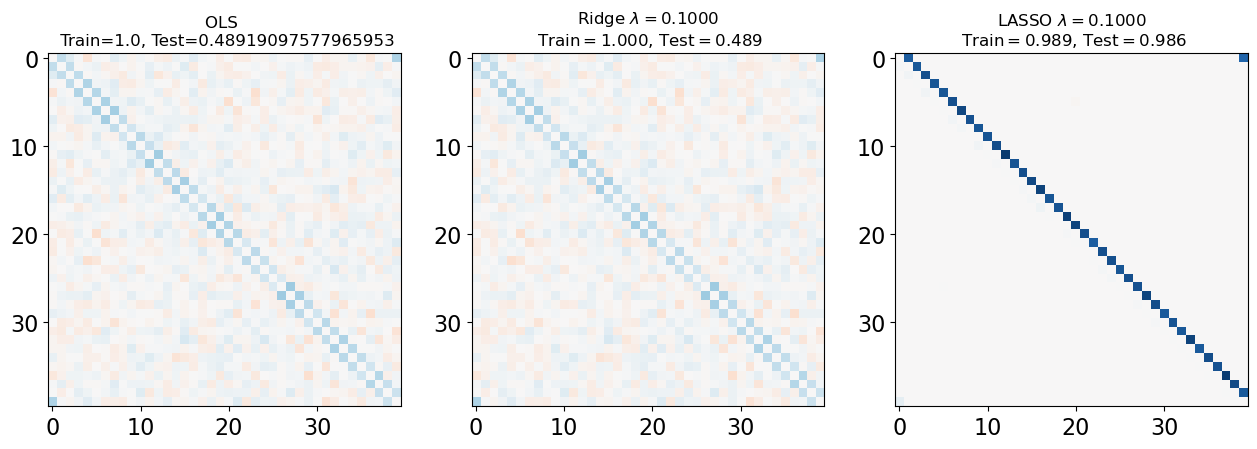

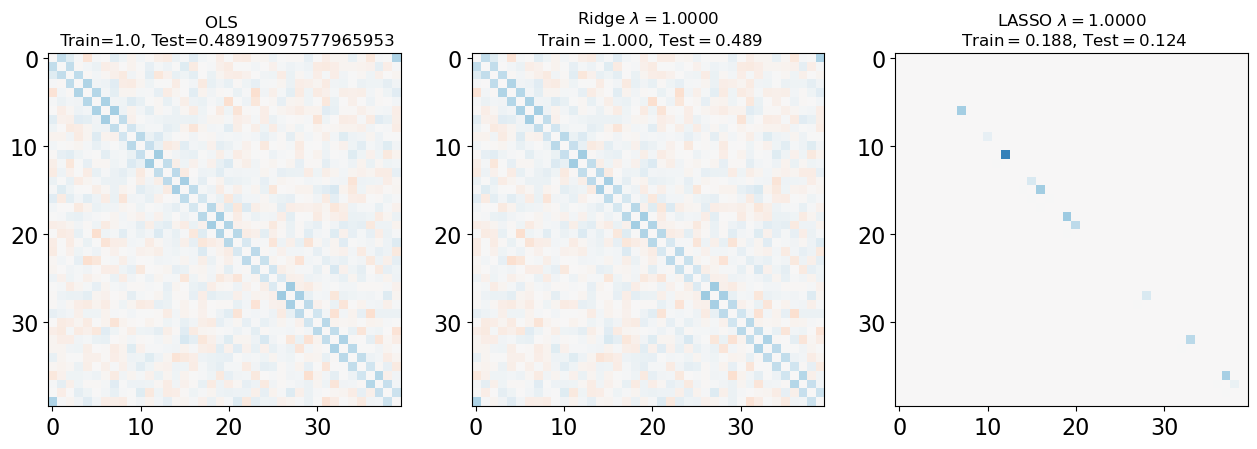

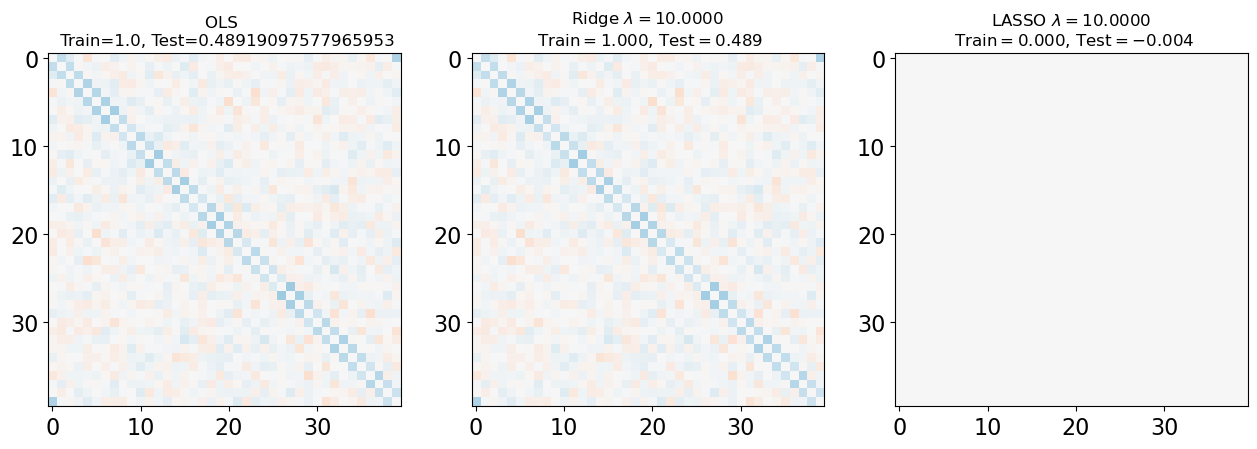

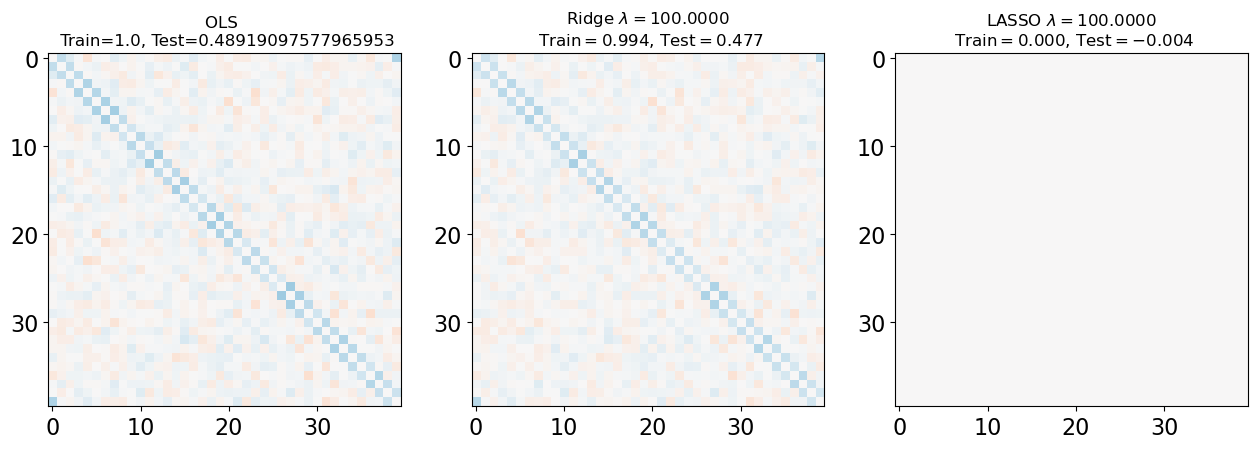

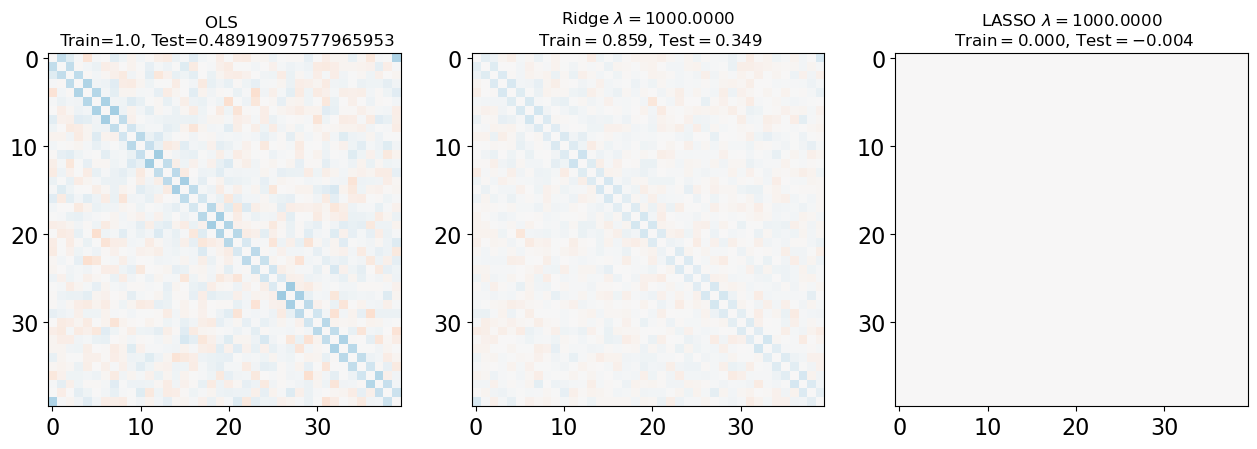

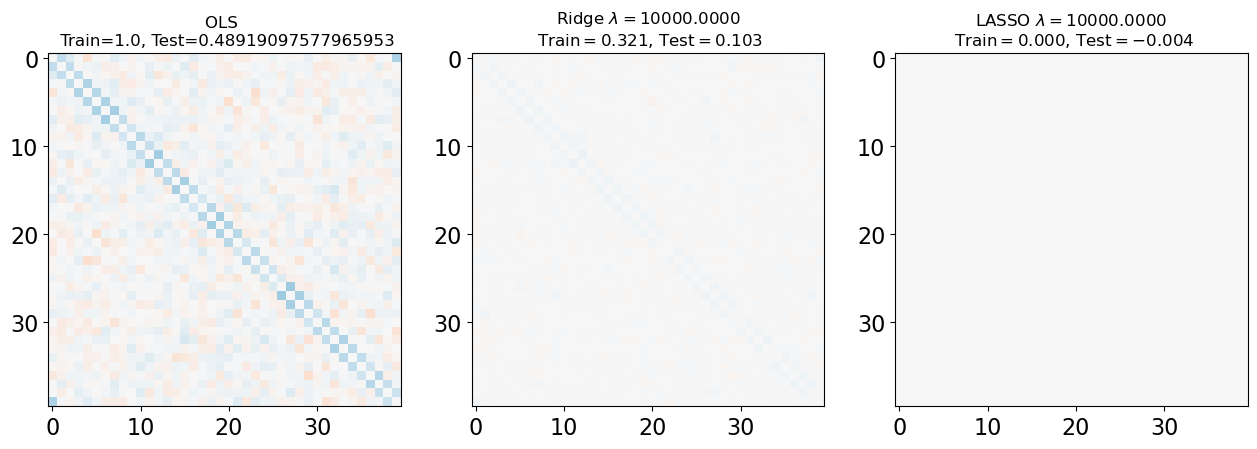

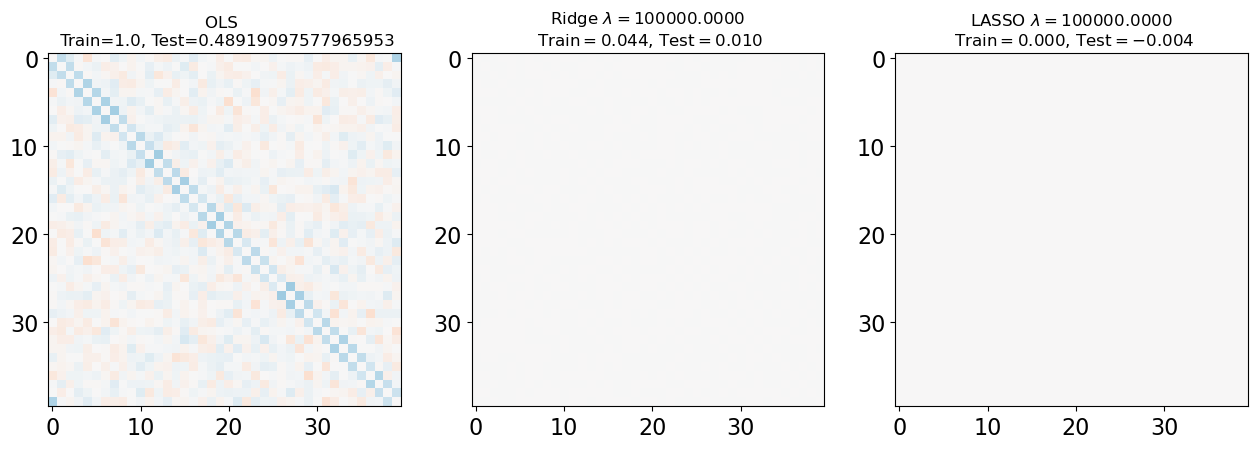

In [58]:


# Instantiate OLS, Ridge, and Lasso models
from sklearn import linear_model
model_ols = linear_model.LinearRegression()
model_l2 = linear_model.Ridge()
model_l1= linear_model.Lasso()

# Set range of values for the regularization
lambdas = np.logspace(-4, 5, 10)

# Load data on subset of samples
n_samples = 400
X_train, X_test = X_all[:n_samples], X_all[n_samples : 3 * n_samples // 2]
y_train, y_test = y_all[:n_samples], y_all[n_samples : 3 * n_samples // 2]

# define lists that will store the error terms
train_error_ols, test_error_ols = list(), list()
train_error_l2, test_error_l2 = list(), list()
train_error_l1, test_error_l1 = list(), list()

#Initialize coefficients for ridge regression and Lasso
coeffs_ols, coeffs_ridge, coeffs_lasso = list(), list(), list()

for lam in lambdas:
    ### ordinary least squares
    model_ols.fit(X_train, y_train) # fit model 
    coeffs_ols.append(model_ols.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_error_ols.append(model_ols.score(X_train, y_train))
    test_error_ols.append(model_ols.score(X_test, y_test))

    ### ridge regression
    model_l2.set_params(alpha=lam) # set regularisation strength
    model_l2.fit(X_train, y_train) # fit model
    coeffs_ridge.append(model_l2.coef_) # store weights
    train_error_l2.append(model_l2.score(X_train, y_train))
    test_error_l2.append(model_l2.score(X_test, y_test))

    ### lasso
    model_l1.set_params(alpha=lam) # set regularisation strength
    model_l1.fit(X_train, y_train) # fit model
    coeffs_lasso.append(model_l1.coef_) # store weights
    train_error_l1.append(model_l1.score(X_train, y_train))
    test_error_l1.append(model_l1.score(X_test, y_test))




    ### plot Ising interaction J
    J_leastsq = np.array(model_ols.coef_).reshape((L, L))
    J_ridge = np.array(model_l2.coef_).reshape((L, L))
    J_lasso = np.array(model_l1.coef_).reshape((L, L))


    fig, axarr = plt.subplots(nrows=1, ncols=3)
    
    axarr[0].imshow(J_leastsq,  cmap="RdBu_r", vmin=-1, vmax=1)
    axarr[0].set_title(f"OLS \n Train={train_error_ols[-1]}, Test={test_error_ols[-1]}")
    ## 3 sig figs
    # axarr[0].set_title('OLS \n Train$=%.3f$, Test$=%.3f$' %(train_error_ols[-1],test_error_ols[-1]))
    axarr[1].set_title('OLS $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lam, train_error_ols[-1],test_error_ols[-1]))
    axarr[0].tick_params(labelsize=16)
    
    axarr[1].imshow(J_ridge,  cmap="RdBu_r", vmin=-1, vmax=1)
    axarr[1].set_title('Ridge $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lam, train_error_l2[-1],test_error_l2[-1]))
    axarr[1].tick_params(labelsize=16)
    
    im=axarr[2].imshow(J_lasso, cmap="RdBu_r", vmin=-1, vmax=1)
    axarr[2].set_title('LASSO $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lam, train_error_l1[-1],test_error_l1[-1]))
    axarr[2].tick_params(labelsize=16)
    
    # divider = make_axes_locatable(axarr[2])
    # cax = divider.append_axes("right", size="5%", pad=0.05, add_to_figure=True)
    # cbar=fig.colorbar(im, cax=cax)
    
    # cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
    # cbar.set_label('$J_{i,j}$',labelpad=15, y=0.5,fontsize=20,rotation=0)
    
    fig.subplots_adjust(right=2.0)
    
    plt.show()

Text(0, 0.5, 'Performance $R^2$')

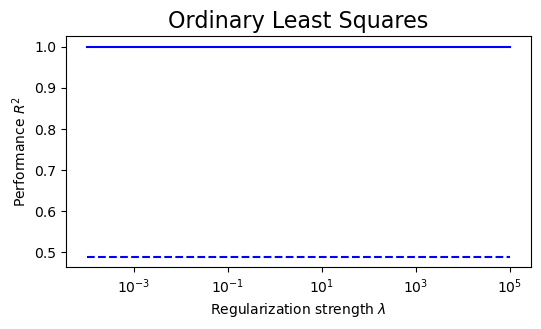

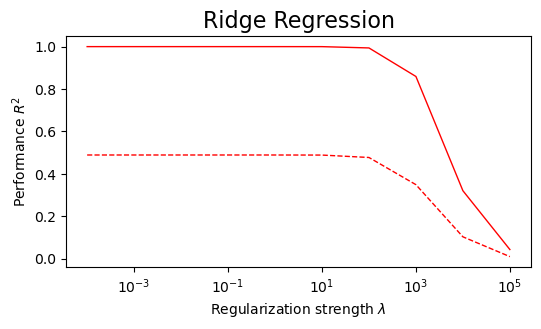

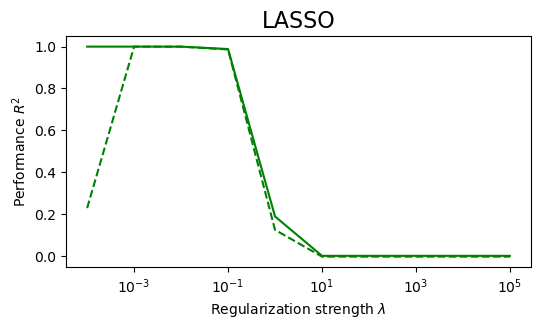

In [61]:
# Plot our performance on both the training and test data
plt.figure(figsize=(6, 3))
plt.semilogx(lambdas, train_error_ols, "b", label="Train (OLS)")
plt.semilogx(lambdas, test_error_ols, "--b", label="Test (OLS)")
plt.title("Ordinary Least Squares", fontsize=16)
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Performance $R^2$")


plt.figure(figsize=(6, 3))
plt.semilogx(lambdas, train_error_l2, "r", label="Train (Ridge)", linewidth=1)
plt.semilogx(lambdas, test_error_l2, "--r", label="Test (Ridge)", linewidth=1)
plt.title("Ridge Regression", fontsize=16)
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Performance $R^2$")

plt.figure(figsize=(6, 3))
plt.semilogx(lambdas, train_error_l1, "g", label="Train (LASSO)")
plt.semilogx(lambdas, test_error_l1, "--g", label="Test (LASSO)")
plt.title("LASSO", fontsize=16)
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Performance $R^2$")


## Understanding our result

It looks like our coupling matrix is pretty sparse, and that the non-zero entries are concentrated along the off diagonal. This means that our Hamiltonian likely corresponds to the nearest-neighbor Ising model

$$
\mathcal{H}(\mathbf{s}^{(i)})=-J\sum_{j=1}^L s_{j}^{(i)}\, s_{j+1}^{(i)}
$$


+ When $\lambda\to 0$ and $\lambda\to\infty$, all three models overfit the data, as can be seen from the deviation of the test errors from unity (dashed lines), while the training curves stay at unity. 

+ While the ordinary least-squares and Ridge regression test curves are monotonic, the LASSO test curve is not -- suggesting the optimal LASSO regularization parameter is $\lambda\approx 10^{-2}$. At this sweet spot, the Ising interaction weights ${\bf J}$ contain only nearest-neighbor terms (as did the model the data was generated from).

+ Notice how Lasso was able to correctly identify that the coupling matrix is non-symmetric, while OLS and Ridge both favored finding symmetric matrices. 

# Hyperparameter tuning

We can imagine that an even more general model would have both regularizers, each with different strengths
$$
\mathcal{L}_{total} = \mathcal{L}_{least-squares} + \lambda_1 \mathcal{L}_{lasso} + \lambda_2 \mathcal{L}_{ridge}
$$
This loss function is sometimes referred to as least-squares with an ElasticNet penalty.


## Why not always use regularizers
+ The issue: we have two arbitrary factors, $\lambda_1$ and $\lambda_2$, which determine how important the L1 and L2 penalties are relative to the primary fitting. These change the available solution space and thus model class
+ These are not "fit" during training like ordinary parameters; rather they are specified beforehand, perhaps with a bit of intuition or domain knowledge, These therefore represent *hyperparameters* of the model
+ Generally speaking, any "choices" we make---amount of data, model type, model parameters, neural network depth, etc are all hyperparameters. How do we choose these in a principled manner?
+ A major question in machine learning: **How do we choose the best hyperparameters for a model?**



## Validation set
+ Hold out some data just for hyperparameter tuning, separate from the test set
+ Don't validate on test, that leads to data leakage and thus overfitting

Best lambda on validation set 0.0005336699231206307


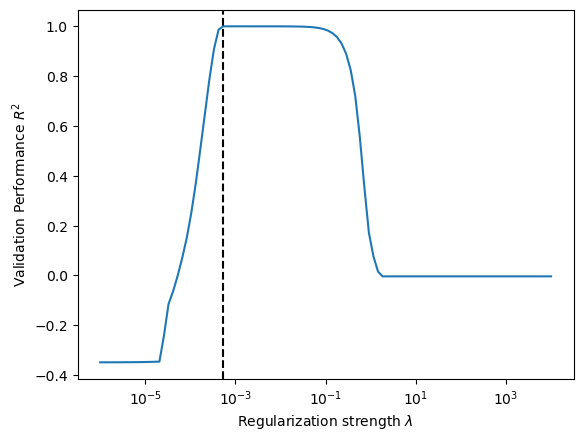

In [62]:
from sklearn import linear_model

# define train, validation and test data sets
X_train, X_val, X_test = X_all[:400], X_all[400 : 600], X_all[600 : 800]
y_train, y_val, y_test = y_all[:400], y_all[400 : 600], y_all[600 : 800]

# the hyperparameter values to check
lambdas = np.logspace(-6, 4, 100)

all_validation_losses = list()

for lam in lambdas:
    model_l1 = linear_model.Lasso(alpha=lam)
    model_l1.fit(X_train, y_train)
    validation_loss = model_l1.score(X_val, y_val)
    all_validation_losses.append(validation_loss)

best_lambda = lambdas[np.argmax(all_validation_losses)]

plt.semilogx(lambdas, all_validation_losses, label="Validation")
plt.axvline(best_lambda, color='k', linestyle='--', label="Best lambda")
plt.xlabel("Regularization strength $\lambda$")
plt.ylabel("Validation Performance $R^2$")

print("Best lambda on validation set", best_lambda)

Now we use the best hyperparameters to train on the full training set, and then evaluate on the test set. This is the final evaluation of our model, and we should not go back and make any changes to hyperparameters or model structure based on the test set results

Test R^2: 0.999999616529093


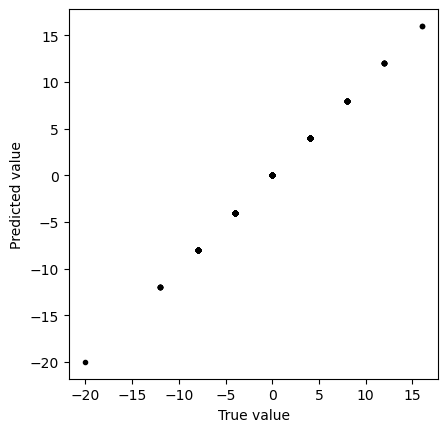

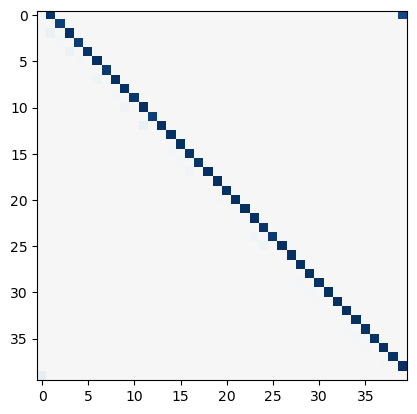

In [63]:
# fit best model 
model_l1 = linear_model.Lasso(alpha=best_lambda)
model_l1.fit(X_train, y_train)

y_test_predict = model_l1.predict(X_test)

plt.figure()
plt.plot(y_test, y_test_predict, ".k")
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.gca().set_aspect(1)

print(f"Test R^2: {model_l1.score(X_test, y_test)}")


# plot Ising interaction J
J_lasso = np.array(model_l1.coef_).reshape((L, L))
plt.figure()
plt.imshow(J_lasso,  cmap="RdBu_r", vmin=-1, vmax=1)
plt.gca().set_aspect(1)

## Cross-validation

+ We repeatedly split-up the train into multiple sub-splits for training and validation
+ For example, if we have 100 train points, we can create five 80:20 "splits", and average the best hyperparameter across the splits
+ If we perform $k$ subsplits, we refer to our procedure as k-fold cross-validation
+ More elaborate splitting methods (random Monte Carlo, importance weighted, etc)


<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/cross_val.png" alt="supervised_learning" style="width: 750px;"/>

Image from [source](https://towardsdatascience.com/cross-validation-k-fold-vs-monte-carlo-e54df2fc179b)

Best lambda on validation set 0.005623413251903491


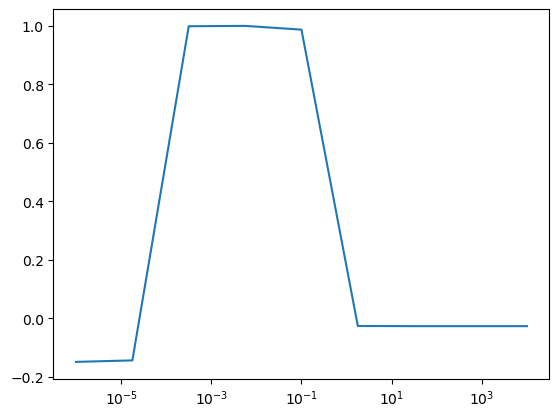

In [64]:
## Cross validation

from sklearn import linear_model

# define train, validation and test data sets
X_train, X_test = X_all[:600], X_all[600 : 800]
y_train, y_test = y_all[:600], y_all[600 : 800]

# the hyperparameter values to check
lambdas = np.logspace(-6, 4, 9)

all_validation_losses = list()
all_validation_stderrs = list()

for lam in lambdas:

    all_val_loss_lam = list()
    all_val_stderrs_lam = list()

    ## Loop over the cross-validation splits
    for k in range(5):

        # Create the training and validation subsets from the training data
        X_train_k = np.concatenate([X_train[:k*100], X_train[(k+1)*100:]])
        y_train_k = np.concatenate([y_train[:k*100], y_train[(k+1)*100:]])
        X_val_k = X_train[k*100:(k+1)*100]
        y_val_k = y_train[k*100:(k+1)*100]


        model_l1 = linear_model.Lasso(alpha=lam)
        model_l1.fit(X_train_k, y_train_k)
        validation_loss = model_l1.score(X_val_k, y_val_k)
        all_val_loss_lam.append(validation_loss)
        all_val_stderrs_lam.append(np.std(model_l1.predict(X_val_k) - y_val_k))

    ## Store the mean and standard error of the validation loss across the splits
    all_validation_losses.append(np.mean(all_val_loss_lam))
    all_validation_stderrs.append(np.mean(all_val_stderrs_lam))

best_lambda = lambdas[np.argmax(all_validation_losses)]
plt.figure()
plt.semilogx(lambdas, all_validation_losses, label="Validation")
print("Best lambda on validation set", best_lambda)

Text(0, 0.5, 'Standard error of the val acc')

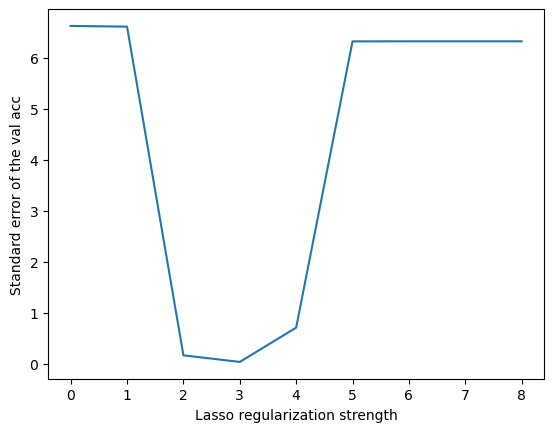

In [65]:
plt.plot(all_validation_stderrs)
plt.xlabel("Lasso regularization strength")
plt.ylabel("Standard error of the val acc")

Now, we can use our unused test dataset to evaluate our model's performance.

Test R^2: 0.9999637493558354


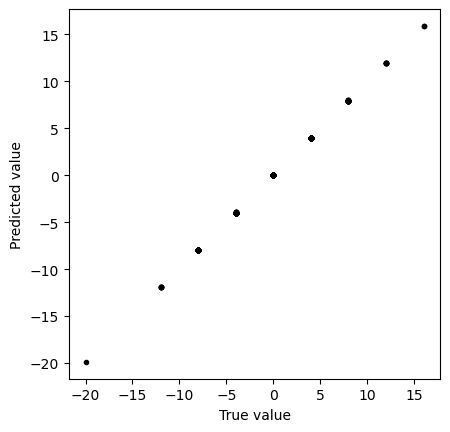

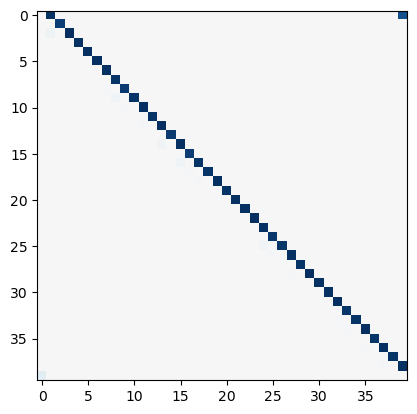

In [66]:
# fit best model 
model_l1 = linear_model.Lasso(alpha=best_lambda)
model_l1.fit(X_train, y_train)

y_test_predict = model_l1.predict(X_test)

plt.figure()
plt.plot(y_test, y_test_predict, ".k")
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.gca().set_aspect(1)

print(f"Test R^2: {model_l1.score(X_test, y_test)}")

# plot Ising interaction J
J_lasso = np.array(model_l1.coef_).reshape((L, L))
plt.figure()
plt.imshow(J_lasso,  cmap="RdBu_r", vmin=-1, vmax=1)
plt.gca().set_aspect(1)

## How many free parameters are in our model?

Linear regression is unique because it's a class of learning model where the number of free parameters is determined by our dataset shape. In our case, we have $L^2$ free parameters, where $L$ is the number of spins in our system.

$$
    y_i = \mathbf{A} \mathbf{X}_i
$$

+ In our Ising example, the fitting parameters $\mathbf{A}$ corresponded to each pair of spins in our coupling matrix $\mathbf{J}$
+ $\mathbf{X}_i$ were our spin product microstates, and $y_i$ was their energies
+ $\mathbf{J} \in \mathbb{R}^{40 \times 40}$ because our inputs (microstates) are on an $L = 40$ lattice, and so we had $1600$ free parameters


## What if we wanted to increase our model complexity?

+ Above, we saw that our model had high variance, and we added bias in the form of regularization to constrain the solutions it found. 

+ What if we instead were getting low training accuracy, indicating that our model class isn't broad enough to describe our data? In that case, we would want a model with *more* trainable parameters.

### Idea: what if we add another weight matrix?

$$
y_i = \mathbf{B} \mathbf{C} \mathbf{X}_i
$$

where $\mathbf{B} \in \mathbb{R}^{40 \times p}$ and $\mathbf{C} \in \mathbb{R}^{p \times 40}$, with $p$ being a hyperparameter that controls the complexity of the model. This "hidden" or "latent" dimensionality allows us to have a more complex model.

However, the problem is that $\mathbf{B} \mathbf{C} \equiv \mathbf{A}\in \mathbb{R}^{40 \times 40}$, so we don't gain any expressivity

### Solution:

$$
y_i = \mathbf{B} \sigma(\mathbf{C} \mathbf{X}_i)
$$

where $\sigma(.)$ is an elementwise nonlinear function, like $\tanh(.)$. Now the model doesn't collapse, so we have $2 \times 40 \times p$ free parameters.

This is a one-layer neural network, with a $p$ unit "hidden" layer. We can always go wider or deeper to further increase the model complexity.

# Appendix

Simulate the Ising model with nearest-neighbor interactions with periodic boundary conditions. The energy of a spin configuration $\boldsymbol{\sigma} = \{\sigma_1,\dots,\sigma_N\}$ is given by

$$
E[\boldsymbol{\sigma}] = -J\sum_{\langle i,j\rangle} \sigma_i \sigma_j
$$

where the sum is over all pairs of nearest neighbors on a $L\times L$ square lattice, and $J$ is the coupling constant. The magnetization is given by

$$
M[\boldsymbol{\sigma}] = \sum_{i=1}^N \sigma_i
$$

In [ ]:
class IsingModel:
    """
    The Ising model with ferromagnetic interactions that encourage nearest neighbors
    to align
    """
    def __init__(self, L, random_state=None):
        self.L = L
        self.random_state = random_state
        
        self.J = np.diag(-np.ones(L - 1), 1)
        self.J [-1, 0] = -1.0 # periodic boundary conditions

    def sample(self, n_samples=1):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        return np.random.choice([-1, 1], size=(n_samples, self.L))

    def energy(self, state):
        return np.einsum("...i,ij,...j->...", states, self.J, states)

model_experiment = IsingModel(40, random_state=0)

# create 10000 random Ising states
states = model_experiment.sample(n_samples=10000)


# calculate Ising energies
energies = model_experiment.energy(states)

print("Input data has shape: ", states.shape)
print("Labels have shape: ", energies.shape)


## Save data
# states.dump("../resources/spin_microstates.npy")
# energies.dump("../resources/spin_energies.npy")